In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import operator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas_bokeh
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.plotting import figure
output_notebook(INLINE)

# pandas_bokeh.output_notebook()
from geopy.distance import great_circle
import gc, os, sys, pickle, random, time, cmath, re
import geopy
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

from contextlib import contextmanager
import multiprocessing
import shap
import shap
from interpret import show

from datetime import datetime
# import librosa
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier, LGBMRegressor
from category_encoders import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
def load_df(dataset):
    if 'train' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    elif 'test' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    elif 'submit' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    return df

print('Download Train and Test Data.\n')
with multiprocessing.Pool() as pool: 
    train, test, submit = pool.map(load_df, ["train", "test", "submit_test"])

  
    
def land_outlier_Bayesian(train, test):
    
    combine = pd.concat([train, test])
    
    for i in combine.columns:
        combine[i].replace([np.inf, -np.inf], np.nan, inplace=True)
    cols = combine.columns[~combine.isna().any()].tolist()
    # non - NaN columns 
    
    cols = [e for e in cols if e not in ('total_price', 'building_id','area_ratio',
                                                 'txn_dt','land_area', 'building_area')]
    try:
        nan_cols.remove('land_area')
    except:pass
    y = combine[combine['land_area']!=0]['land_area']
    model = BayesianRidge(normalize=True)
    model.fit(combine[combine['land_area']!=0][cols], y)

    result = model.predict(combine[combine['land_area']==0][cols])
    combine.loc[combine['land_area']==0,'land_area'] = result

    train = combine[combine['total_price'].notnull()]
    test = combine[combine['total_price'].isnull()]
    del combine; gc.collect()
    
    return train, test

def land_outlier_correction(train, test):
    
    train.loc[(train['land_area']==0)&(train['XIV_10000']==14502)
              &(train['building_complete_dt']==8190),'land_area']=9.642834

    train.loc[(train['land_area']==0)&(train['building_complete_dt']==10228),
                  'land_area'] = 44.889814
    train.loc[(train['land_area']==0)&(train['building_complete_dt']==11020)&
              (train['village']==1888),'land_area'] = 13.106
    train.loc[(train['land_area']==0)&(train['lon']==119.32)&(train['lat']==-37.7)&
              (train['building_complete_dt']==11416),'land_area']= 2.222

    test.loc[(test['land_area']==0)&(test['XIV_5000']==11882)&
             (test['total_floor']==10),'land_area']= 2.222

    test.loc[(test['land_area']==0)&(test['lon']==119.37)&(test['lat']==-37.66)&
         (test['building_complete_dt']==6606),'land_area']= 2.222

    test.loc[(test['land_area']==0)&(test['lon']==119.32)&
             (test['lat']==-37.72),'land_area'] = 13.106
    
    
    return train, test


def city_median_transform(train, test):

    train['city'] = train['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    test['city'] = test['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})

    median_price = {'Changhua': 1.091, 'Hsinchu': 2.9586,
     'Kaohsiung': 0.968,'Keelung': 0.334,
     'Miaoli': 0.9681, 'NewTaipei': 4.276,
     'Pingtung': 0.0001,'Taichung': 2.334,
     'Tainan': 1.20641,'Taipei': 11.51634,
     'TaoYuan': 1.6873}
    
    train['city'] = train['city'].map(median_price)
    test['city'] = test['city'].map(median_price)
    
    return train, test

def city_name_transform(train, test):
    train['city'] = train['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 
                                       9:'Hsinchu', 17:'Miaoli', 12:'Taichung', 6:'Changhua', 
                                       14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    test['city'] = test['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan',
                                     9:'Hsinchu', 17:'Miaoli', 12:'Taichung', 6:'Changhua', 
                                     14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})

    return train, test
                                     
def feature_engineer(train, test):
    
    train['floor_2_top'] = train['total_floor'] -  train['txn_floor']
    train['area_ratio'] = train['building_area']/train['land_area'] # Very Powerful
    train['XIII_diff'] = train['XIII_10000'] - train['XIII_5000']
    train['XIII_diff_4_3'] = train['XIII_10000'] - train['XIII_1000']
    train['XIII_diff_3_2'] = train['XIII_1000'] - train['XIII_500']


    test['floor_2_top'] = test['total_floor'] -  test['txn_floor']
    test['area_ratio'] = test['building_area']/test['land_area'] # Very Powerful
    test['XIII_diff'] = test['XIII_10000'] - test['XIII_5000']
    test['XIII_diff_4_3'] = test['XIII_10000'] - test['XIII_1000']
    test['XIII_diff_3_2'] = test['XIII_1000'] - test['XIII_500']
    return train, test


# 中位數房價 高低：
# ['Taipei', 'NewTaipei', 'Hsinchu', 'Taichung', 'TaoYuan', 'Tainan',
#'Changhua', 'Miaoli', 'Kaohsiung', 'Keelung', 'Pingtung']


# train['PubPlace_each_floor'] = train['area_diff']/train['total_floor']
# test['PubPlace_each_floor'] = test['area_diff']/test['total_floor']

# train['logit_build_trade_diff'] = 1/(1+np.exp(-(train['txn_dt'] - train['building_complete_dt'])/train['txn_dt']) ) 
# test['logit_build_trade_diff'] = 1/(1+np.exp(-(test['txn_dt'] - test['building_complete_dt'])/test['txn_dt']) )


def median_income_rulebase(train, test):
    combine = pd.concat([train, test])
    del train, test;
    gc.collect()
    print('Initial # of Median income NaN {}'.format(combine[combine['village_income_median'].isnull()].shape))
    collection = list(combine[combine['village_income_median'].isnull()]['lonlat'].unique())
    for i in collection:
        if combine[combine['lonlat']==i]['village'].nunique()>2:

            if combine[combine['lonlat']==i]['village_income_median'].std() <=30:
                combine.loc[(combine['village_income_median'].isnull())&(combine['lonlat']==i), 
                            'village_income_median'] = combine[combine['lonlat']==i]['village_income_median'].mean()
    
    print('Processed # of Median income NaN {}'.format(combine[combine['village_income_median'].isnull()].shape))

    train = combine[combine['total_price'].notnull()]
    test = combine[combine['total_price'].isnull()]
    del combine;
    return train, test

def parking_rulebase(train, test):
    combine = pd.concat([train, test])
    del train, test;
    assert combine[combine['parking_way']==2][['parking_area']].shape[0] == combine[(combine['parking_way']==2)&(combine['parking_area'].isnull())].shape[0] 
#     assert combine[combine['parking_way']==2][['parking_price']].shape[0] == combine[(combine['parking_way']==2)&(combine['parking_price'].isnull())].shape[0] 
#     combine.loc[(combine['city']==0.0001)&(combine['city']==0.9681)&(combine['city']==1.091)&(combine['parking_way']==2),'parking_area'] = 0
    combine.loc[(combine['parking_way']==2),'parking_area'] = 0
#     combine.loc[combine['parking_way']==2,'parking_price'] = 0
    train = combine[combine['total_price'].notnull()]
    test = combine[combine['total_price'].isnull()]
    del combine;
    return train, test

def parking_way_relabel(train, test):
    re_map = { 2:0, 1:1, 1:2}

    train['parking_way'] = train['parking_way'].map(re_map)
    test['parking_way'] = test['parking_way'].map(re_map)
    return train, test

Download Train and Test Data.



# 經緯度轉換

In [17]:
def coordinate_transform(train, test):

    X1 = np.matrix([(117.2,-40.01), (118.82, -37.64), (117.17, -38.87)]) #(118.02,-37.93)])
    X2 = np.matrix([(120.713287,21.987057), (121.019332, 24.787207), (120.587535,23.083790)])
    T = inv(X1.T * X1) * X1.T * X2
    coor_trans_trn = np.matrix(train[['lon', 'lat']])*T
    coor_trans_sub = np.matrix(test[['lon', 'lat']])*T
    train['lon'] = np.array(coor_trans_trn[:,0]).squeeze()
    train['lat'] = np.array(coor_trans_trn[:,1]).squeeze()

    test['lon'] = np.array(coor_trans_sub[:,0]).squeeze()
    test['lat'] = np.array(coor_trans_sub[:,1]).squeeze()
    return train, test
# train, test = coordinate_transform(train, test)

# Cluster Target Encode

In [54]:
class cluster_target_encoder:
    def __init__(self, nclusters = 3, n_init = 100 , seed=0, njobs = -1):
        self.seed = seed
        self.nclusters = nclusters
        self.njobs = njobs
        self.n_init = n_init # default 10
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean()
        
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'], index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters, n_init =self.n_init, random_state=self.seed, n_jobs = self.njobs)
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
        
    def transform(self,X):
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

    
def kmeans_target_encoder(train, test, clusters = 3):
    train['lonlat'] = train['lon'].apply(lambda x: str((int(x*100)))) + train['lat'].apply(lambda x: str((int(x*-100))))
    test['lonlat'] = test['lon'].apply(lambda x: str((int(x*100)))) + test['lat'].apply(lambda x: str((int(x*-100))))

    cate = 'lonlat'

    X_train = train.drop(['total_price'],axis=1)
    y_train = np.log1p(train['total_price'])

    encoder = cluster_target_encoder(nclusters=clusters, n_init = 100, seed=2019, njobs = -1)
    labels_train = encoder.fit_transform(X_train[cate], y_train)
    labels_test = encoder.transform(test[cate])

    est = LGBMClassifier()

    est.fit(X_train.select_dtypes(include=[np.number]),labels_train)

    labels_test[np.isnan(labels_test)] = est.predict(
        test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]

    train['labels'] = labels_train
    test['labels'] = labels_test
    
    ######################## Ordinal re-Label #######################
    from collections import OrderedDict
    from operator import itemgetter
    m_dict = {i: np.median(np.log1p(train['total_price']).values[train['labels']==i]) for i in range(clusters)}
    d = OrderedDict(sorted(m_dict.items(), key=itemgetter(1), reverse=False))
    re_map = {k: i for i, (k, _) in enumerate(d.items())}
    del d, m_dict;gc.collect()
    
    train['labels'] = train['labels'].map(re_map)
    test['labels'] = test['labels'].map(re_map)
    plt.figure(figsize=(10,5))
    plt.hist(y_train.values[train['labels']==0],bins=70,label='cluster 0')
    plt.hist(y_train.values[train['labels']==1],bins=70,label='cluster 1')
    plt.hist(y_train.values[train['labels']==2],bins=70,label='cluster 2')
    # plt.hist(y_train.values[train['labels']==3],bins=70,label='cluster 3')
    # plt.hist(y_train.values[train['labels']==4],bins=70,label='cluster 4')

    plt.legend()
    plt.title('Train targets distribution for all clusters')
    # plt.xlim((10,22))
    plt.show()
    return train, test

train, test = kmeans_target_encoder(train, test, clusters=3)


{0: 1, 1: 0, 2: 2}

In [9]:
# labels_test[np.isnan(labels_test)].shape()
if False:
    cross_val_score(
        X = X_train.select_dtypes(include=[np.number]),
        y = labels_train,
        estimator = LGBMClassifier(),
        cv = 5,
        scoring = 'roc_auc')

In [10]:
train, test = kmeans_target_encoder(train, test, clusters=3)
train, test = land_outlier_correction(train, test)
train, test = land_outlier_Bayesian(train, test)
train, test = city_median_transform(train, test)
 
# train, test = city_name_transform(train, test) # Only for EDA
train, test = median_income_rulebase(train, test)
train, test = parking_rulebase(train, test)

train, test = parking_way_relabel(train, test)
train, test = feature_engineer(train, test)

combine = pd.concat([train, test])
target = train['total_price']
# combine['building_yr'] = np.round(combine['building_complete_dt']/365,0)-50#- 48.62
# combine['txn_dt_yr'] = np.round(combine['txn_dt']/365,0)-50

Initial # of Median income NaN (1326, 237)
Processed # of Median income NaN (1278, 237)


In [21]:
combine.isnull().sum().sort_values(ascending=False).head(7)

parking_area             66397
parking_price            53775
floor_2_top              18541
txn_floor                18541
parking_way              12736
total_price              10000
village_income_median     1278
dtype: int64

## Village income median
1. 查詢lonlat，看看差異性
2. VIM 只有高雄七年間，變動劇烈下降，其餘都沒變（薪資沒調）
3. VIM 跟 TP 相關性
    - Kaohsiung -0.48587340565711784
    - NewTaipei 0.29220999227867184
    - Taichung 0.1362150551754448
    - Miaoli -0.20781607263306837
    - TaoYuan -0.6869879978116139
    - Taipei 0.1344224339183379
    - Tainan 0.0026884224079945
    - Keelung 0.043792577766696296
    - Changhua -0.22675777250947332
    - Pingtung 0.20471796667982148
    - Hsinchu 0.6840542171880224

4. village = 1705，很大可能是 新竹市東區關新里。
    - median income 全資料最大
    - 2百42萬元


In [8]:
combine['village_income_median'].describe()

count    68674.000000
mean       674.624996
std        140.469560
min        411.000000
25%        583.000000
50%        642.000000
75%        729.000000
max       1851.000000
Name: village_income_median, dtype: float64

In [89]:
plt.figure(figsize=(10,5))
city = ['Kaohsiung', 'Hsinchu']
for i in city:
    
#     x = combine[combine['city']==i].groupby('txn_dt_yr')['village_income_median'].median()
    x = combine[combine['village']==1705].groupby('txn_dt_yr')['village_income_median'].median()
#     plt.legend()
    plt.plot(x,label=i)
    plt.xlabel("Year")
    plt.ylabel("Median income")
    plt.legend(loc='best')

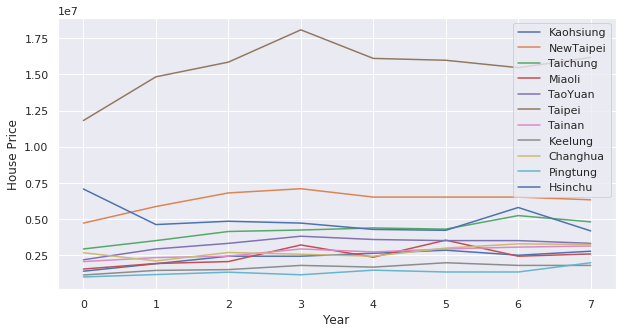

In [88]:
plt.figure(figsize=(10,5))

for i in combine.city.unique():
    
    x = combine[combine['city']==i].groupby('txn_dt_yr')['total_price'].median()
    
#     plt.legend()
    plt.plot(x,label=i)
    plt.xlabel("Year")
    plt.ylabel("House Price")
    plt.legend(loc='best')

In [85]:
from scipy.stats.stats import pearsonr   

for i in combine.city.unique():
    
    x = combine[combine['city']==i].groupby('txn_dt_yr')['village_income_median'].mean()
    x1 = combine[combine['city']==i].groupby('txn_dt_yr')['total_price'].mean()
    
    print(i, np.corrcoef(x, x1)[0,1])

Kaohsiung -0.48587340565711784
NewTaipei 0.29220999227867184
Taichung 0.1362150551754448
Miaoli -0.20781607263306837
TaoYuan -0.6869879978116139
Taipei 0.1344224339183379
Tainan 0.0026884224079945
Keelung 0.043792577766696296
Changhua -0.22675777250947332
Pingtung 0.20471796667982148
Hsinchu 0.6840542171880224


## Parking Recovery
- 'parking_way' 車位停放方式 // 3 
- 'parking_area' 車位面積
- 'parking_price'

Q: 驗證 具備停車面積，就一定有停車價位， vice versa.

What I Found:

Q: 需要買停車位的縣市，應該是大城市(cnt/%)
- [x]  新北，台北，桃園，台中，高雄，新竹 (cnt)
- [x]  新北，桃園，台北，新竹，台中，基隆 (%)

Q: No need 買停車位的縣市，應該是small城市 (cnt/%)
- [ ]  新北，台北，桃園，台中，高雄 (cnt)
- [x]  苗栗，屏東，台南，高雄，彰化 (%)

```python
D = {
3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 
5:'Pingtung'}

Temp = {}
Ans = {}
for i in combine['city'].unique():
    Temp[i] = combine[(combine['parking_area'].isnull())&(combine['city']==i)].shape[0]    
    Temp[i]/= combine[combine['city']==i].shape[0]
    Ans[D[i]] = Temp[i]

sorted(Ans.items(), key=operator.itemgetter(1))
```

有停車面積，跟價位，不會具備 `parking_way = 2`
```
combine[combine['parking_price'].notnull()]['parking_way'].value_counts()
combine[combine['parking_area'].notnull()]['parking_way'].value_counts()
```
   - Hypothesis: 停車方式2 = 路邊停車？
       - [x] 停車方式2，高到低：屏東，苗栗，彰化，台南 (9) 
       


## Recovery
- 要還原area

### What I Found
   - `building_complete_dt` 有無停車位 var 很大 1 order
   - `txn_dt` 沒這問題
```python
train[train['parking_area'].isnull()][['building_complete_dt','txn_dt']].var()
train[train['parking_area'].notnull()][['building_complete_dt','txn_dt']].var()
```
   - [Bayesian Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge)

In [7]:
combine['building_yr'] = np.round(combine['building_complete_dt']/365,0)#- 48.62
combine['txn_dt_yr'] = np.round(combine['building_complete_dt']/365,0)#- 48.62

In [ ]:
# combine[combine['parking_area'].notnull()].groupby(['city','building_yr'])['parking_price'].mean()

In [10]:
combine[combine['parking_area'].notnull()][['building_complete_dt','txn_dt']].var()

building_complete_dt    8.592659e+06
txn_dt                  5.647462e+05
dtype: float64

Official Metrics Test Score:  6667.85
Shape Trn (60000, 242) Sub (10000, 242)
Training until validation scores don't improve for 2000 rounds.
[6000]	training's l2: 0.00352424	valid_1's l2: 0.0341396
[12000]	training's l2: 0.00098844	valid_1's l2: 0.0337335
[18000]	training's l2: 0.000426675	valid_1's l2: 0.0336935
Early stopping, best iteration is:
[19783]	training's l2: 0.000352136	valid_1's l2: 0.0336842
Fold 1 Hit-Rate plus MAPE: 5882.875473313574 

Fold 1 Hit-Rate 0.5882 

Training until validation scores don't improve for 2000 rounds.
[6000]	training's l2: 0.00346858	valid_1's l2: 0.0421654
[12000]	training's l2: 0.000981366	valid_1's l2: 0.0416295
[18000]	training's l2: 0.000405078	valid_1's l2: 0.0415658
Early stopping, best iteration is:
[18080]	training's l2: 0.000401345	valid_1's l2: 0.041564
Fold 2 Hit-Rate plus MAPE: 5832.8686528683675 

Fold 2 Hit-Rate 0.5832 

Training until validation scores don't improve for 2000 rounds.
[6000]	training's l2: 0.00349389	valid_1's l2: 0.

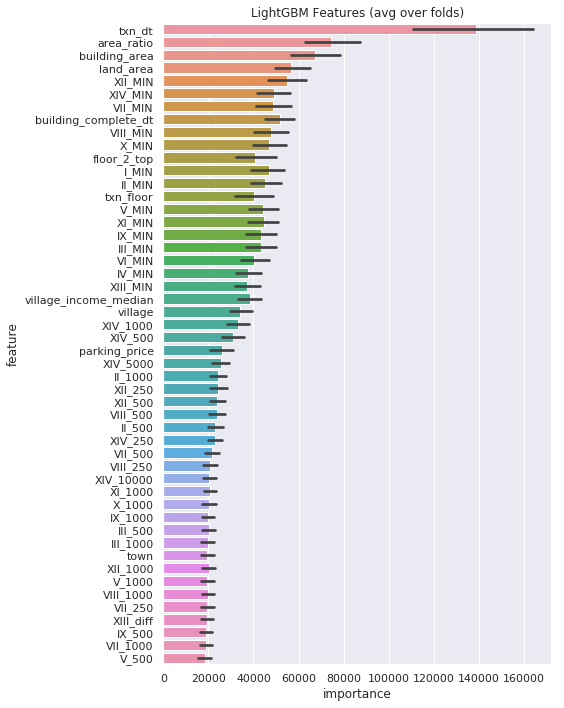

In [13]:
dt_today = datetime.today()

def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(50).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.savefig('shap_{}.png'.format(dt_today.strftime("%m_%d")))
    plt.tight_layout()
    plt.show()
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_{}.png'.format(dt_today.strftime("%m_%d")))
    
def hit_rate(y_true, y_pred):
    return np.mean(np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)]))

def Mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true)/y_true))

def score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return (np.round(hit_rate(y_true, y_pred), 4)*1e4 + 1 - Mape(y_true, y_pred))

def model(trn, sub, folds, save, SHAP):
    print('Official Metrics Test Score: ',score(np.array([1000,1000,1000]), np.array([1300,1100,1050])))
    trn_shape = trn.shape[0]
    print('Shape Trn {} Sub {}'.format(trn.shape, sub.shape))
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat','CTV']]
    combine = pd.concat([trn[feats], sub[feats]])
    
    average = 0
    for col in feats:
        average += np.array(combine[col].rank(ascending=1))
    average = average/len(feats)
    combine['AVERAGE'] = average
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat','CTV']]

    trn = combine.iloc[:trn_shape, :]
    sub = combine.iloc[trn_shape:, :]
    
    del combine; gc.collect()
    X = trn[feats]
    y = np.log1p(target)    
    
    sss = KFold(n_splits=folds, shuffle=True, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(trn.shape[0])
    sub_preds = np.zeros(sub.shape[0])
    output = []

    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMRegressor(n_estimators=100000,
#                             objective='fair',
                            learning_rate =  0.01,#0.003,
                            num_leaves=150,                
                            feature_fraction = 0.5, # sub_feature ([x]0.4), ([O]0.5)
                            bagging_fraction= 0.8, # subsample
#                             lambda_l2 = 0.1,
#                             bagging_freq = 5,
#                             min_data_in_leaf= 30,
#                             min_sum_hessian_in_leaf= 10,
#                             tree_learner='serial',
#                             boost_from_average='false',
#                             device_type='gpu',
#                             gpu_use_dp=True,
                            silent=-1,
                            verbose=-1,
                            n_jobs=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_train, y_train),(X_test, y_test )], 
#                 categorical_feature  = ['town'],
                verbose= 6000, early_stopping_rounds= 2000)
        
        y_pred = np.expm1(clf.predict(X_test, num_iteration=clf.best_iteration_))
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate plus MAPE: {}'.format(score(np.expm1(y_test), y_pred)),'\n')
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate {}'.format(hit_rate(np.expm1(y_test), y_pred)),'\n')
        
        if save:
            print('Saving model fold {}'.format(fold_ + 1))
            filename = './pickle/Lgb_{}.sav'.format(fold_ + 1)
            pickle.dump(clf, open(filename, 'wb'))
            print('\n')

        oof_preds[test_index] = y_pred
        sub_preds += clf.predict(sub[feats], num_iteration=clf.best_iteration_) / sss.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        if SHAP:
            fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(X_test)[:,:sub[feats].shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        del X_train, X_test;
        gc.collect()
        
    print('Full Hit-Rate plus MAPE score: {}'.format(score(target, oof_preds),'\n'))
    output.append(sub_preds)

    submission_file_name = "submit_cv_{}_{}.csv".format(score(target, oof_preds), dt_today.strftime("%m_%d"))
    submit['total_price'] = np.mean(output, axis=0)
    submit[['building_id', 'total_price']].to_csv(submission_file_name, index= False)   
    
    display_importances(feature_importance_df)
    
    if SHAP:
        display_shapley_values(feature_importance_df)
        
    return feature_importance_df, oof_preds, sub_preds


feature_importance_df, oof_preds, sub_preds = model(train , test, folds=12, save = False, SHAP = False)



- Full Hit-Rate plus MAPE score: 5871.873

In [8]:
print('Full Hit-Rate plus MAPE score: {}'.format(score(target, oof_preds),'\n'))

Full Hit-Rate plus MAPE score: 5871.873754474609


In [9]:
# display_shapley_values(feature_importance_df)

## Checking place

In [22]:
def Tell_me_Why(train, target, num_fold = 12, shuffle = True, random_state = 0, num_feas = 7):
    """
    在訓練過程中，有一些Fold成績很糟糕，為什麼？
    檢視基本的統計數據，從 diff_mean / abs(diff_std)^2 
    排序去看
    PS, 請確認random state 要一樣
    """
    feature_names = list(train.select_dtypes(include=[np.number]).columns)

    X = train[feature_names ]
    y = np.log1p(target)
    sss = KFold(n_splits = num_fold, shuffle = shuffle, random_state = random_state)

    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]


        feature_stats = pd.DataFrame({'feature': feature_names})
        feature_stats.loc[:, 'train_mean'] = np.nanmean(X_train[feature_names].values, axis=0).round(4)
        feature_stats.loc[:, 'test_mean'] = np.nanmean(X_test[feature_names].values, axis=0).round(4)
        feature_stats.loc[:, 'train_std'] = np.nanstd(X_train[feature_names].values, axis=0).round(4)
        feature_stats.loc[:, 'test_std'] = np.nanstd(X_test[feature_names].values, axis=0).round(4)
        feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(X_train[feature_names].values), axis=0).round(3)
        feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(X_test[feature_names].values), axis=0).round(3)
        feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
        feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
        feature_stats = feature_stats.sort_values(by='train_test_mean_diff', ascending=False)
        print('Fold: ', fold_+1, feature_stats[['feature', 'train_test_mean_diff']].head(num_feas),'\n')

Tell_me_Why(train, target, num_fold = 12, shuffle = True, random_state = 0, num_feas = 7)

Fold:  1            feature  train_test_mean_diff
222   parking_area              0.048396
225    total_floor              0.038981
211       doc_rate              0.035714
223  parking_price              0.035548
187           X_10              0.033333
236     area_ratio              0.031547
224    parking_way              0.029951 

Fold:  2           feature  train_test_mean_diff
164        XIV_50              0.040586
1         III_100              0.039669
222  parking_area              0.039201
5          III_50              0.037755
4         III_250              0.037175
46         IX_250              0.036569
93        VII_250              0.032501 

Fold:  3            feature  train_test_mean_diff
223  parking_price              0.051564
173          XI_10              0.044346
103          VI_10              0.038788
211       doc_rate              0.035714
51   IX_index_1000              0.034227
232      txn_floor              0.032838
187           X_10              0.

In [ ]:
percentile = 0.8 ## tweak me
best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean']) \
                                                           .sort_values(by="mean", ascending=False).reset_index()
best_features = best_features[:int(best_features.shape[0]*percentile)]["feature"].values
print("## Using {} features =".format(len(best_features)), best_features)
with timer("Run LightGBM with kfold"):
    train_df = train[best_features]
    test_df = test[best_features]
    feature_importance_df, oof_preds, sub_preds = model(train_df , test_df, folds=12, save = False, SHAP = False)

In [13]:
X_test.city.nunique()

11

In [14]:
import lightgbm as lgb
model_num = 1

file = open("Lgb_{}.sav".format(model_num ),'rb')
gbm = pickle.load(file)
graph = lgb.create_tree_digraph(gbm)
graph.render(view=True)

import lightgbm
model_num = 1
with open('./pickle/Lgb_{}.sav'.format(model_num ), 'rb') as file:
    gbm = pickle.load(file)
    
graph = lgb.create_tree_digraph(gbm)
graph.render(view=True)

# Error Analysis
    - 從統計看出 差異最大 std 來自於 real Max 被低估

In [6]:
def hit_rate_all(y_true, y_pred):
    return np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)])

train['hit_rate'] = hit_rate_all(target, oof_preds)
train['pred'] = oof_preds
train[train['hit_rate']==0].shape
train[train['hit_rate']==0].to_csv('error.csv', index=False)

In [7]:
train['city'] = train['city'].map( { 1.091:'Changhua',  2.9586:'Hsinchu',
                                  0.968:'Kaohsiung',0.334:'Keelung',
                                  0.9681:'Miaoli',  4.276:'NewTaipei',
                                  0:'Pingtung', 2.334:'Taichung',
                                  1.20641:'Tainan', 11.51634:'Taipei',
                                  1.6873:'TaoYuan'})
train[train['hit_rate']==0]['city'].value_counts()


NewTaipei    6597
Taipei       4153
Kaohsiung    3860
Taichung     3185
Tainan       2400
TaoYuan      2290
Pingtung      723
Miaoli        531
Hsinchu       483
Changhua      441
Keelung       386
Name: city, dtype: int64

In [8]:
train['city'].value_counts()

NewTaipei    19664
Taipei       10756
Kaohsiung     7964
Taichung      7264
Tainan        4704
TaoYuan       4676
Pingtung      1224
Hsinchu       1125
Miaoli         984
Changhua       826
Keelung        813
Name: city, dtype: int64